# Lung Cancer Analysis Assignment 
The objective of this assignment is to quantitatively and qualitatively evaluate the performances of a detection model that fits bounding boxes around lung nodules in CT scans.

## Data analysis
The dataset is composed by a CSV file and a folder containing images in numpy format (`.npy`).
 
The images are CT scan slices on which lung nodules are present. The slices are given as numpy files containing a 2D array data. Their values are CT Hounsfield units with the lung being visualized usually with the range \[-1000, 300\].

The CSV file instead contains information about the lung nodule characteristics and bounding box data. Each row represents a nodule detection and has the following fields:
- _scan-name_: name of the scan
- _nodule-image-name_: name of the image that contains the nodule
- _nodule-image-size-x_: width of the nodule image
- _nodule-image-size-y_: height of the nodule image
- _gt-composition_: composition of the nodule according to the ground truth. Nodules can be classified according to their appearance (`non-solid`; `part-solid`; `solid`; `unknown`)
- _pred-x-start_: start coordinate of the predicted bounding box in X dimension (wrt the full nodule image; inclusive)
- _pred-x-end_: end coordinate of the predicted bounding box in X dimension (wrt the full nodule image; exclusive)
- _pred-y-start_: start coordinate of the predicted bounding box in Y dimension (wrt the full nodule image; inclusive)
- _pred-y-end_: end coordinate of the predicted bounding box in Y dimension (wrt the full nodule image; exclusive)
- _gt-x-start_: start coordinate of the ground truth bounding box in X dimension (wrt the full nodule image; inclusive)
- _gt-x-end_: end coordinate of the ground truth bounding box in X dimension (wrt the full nodule image; exclusive)
- _gt-y-start_: start coordinate of the ground truth bounding box in Y dimension (wrt the full nodule image; inclusive)
- _gt-y-end_: end coordinate of the ground truth bounding box in Y dimension (wrt the full nodule image; exclusive)

The module fits some bounding boxes around lung nodules that are represented by _pred-x-start_, _pred-x-end_, _pred-y-start_, _pred-y-end_. On the other hand, the ground truth bounding boxes are represented by _gt-x-start_, _gt-x-end_, _gt-y-start_, _gt-y-end_. These are the most useful information regarding the detection capabilities of the module and we're going to use these coordinates to analyze the module performances. Another useful information is the _gt-composition_ field that we can use to perform the same analysis for each lung nodule type.

By running the following cell, we prepare the data for the analysis, loading the images into the dataframe and removing columns that are not useful for our data.

To execute this notebook, it is necessary to download the dataset from [this link](https://drive.google.com/file/d/1Xfm6K9Zie5zpQ-jRaYzGo8k4t4MIc-f1/view?usp=sharing) in the same directory of this notebook. After downloading the file, execute the following code cell to unzip the downloaded file and load the dataset, which creates a Pandas dataframe by reading the CSV files, adding the image data to each row by opening image files by means of the _nodule-image-name_ field and finally removes the columns _scan-name_, _nodule-image-size-x_ and _nodule-image-size-y_ that are not useful for this analysis.

In [1]:
import zipfile
from src.data_manager import load_dataset
import os

# unzip the downloaded file
zip_path = "mls-assignment.zip"
dest_path = "data"

if not os.path.exists(dest_path):
    os.makedirs(dest_path)
    print(f"Folder '{dest_path}' created.")

print(f"Unzipping {zip_path} into {dest_path}...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(dest_path)
print(f"Done.")

print("Loading the dataframe...")
original_df = load_dataset(dataset_folder="data/mls-assignment")
print("Done.")

Unzipping mls-assignment.zip into data...
Done.
Loading the dataframe...
Done.


## Methodology
The main metric that we are going to use for the evaluation task is the **Intersection over Union (IoU)** computed between the ground truth and predicted bounding box. Intersection over Union is computed by the formula
$$ IoU = \frac{area\ of\ intersection}{area\ of\ union} $$
where the two areas are computed between the areas occupied by the two boxes. This metric generally indicates how much two bounding boxes overlap and thus gives us an hint about the precision of the model in matching or getting as close as possible to the ground truth bounding boxes.

By computing this metric for each sample in the dataset, we can then define a threshold for the IoU to decide whether a detection is a True Positive, namely a good detection, or not.

We first compute the IoU metric between the ground truth bounding box and the predicted bounding box for each sample in the dataset.

In [2]:
from src.metrics import compute_iou_dataset

original_df = compute_iou_dataset(dataset_df=original_df)

We then plot the IoU distribution to see how the IoU is distributed across the whole range.

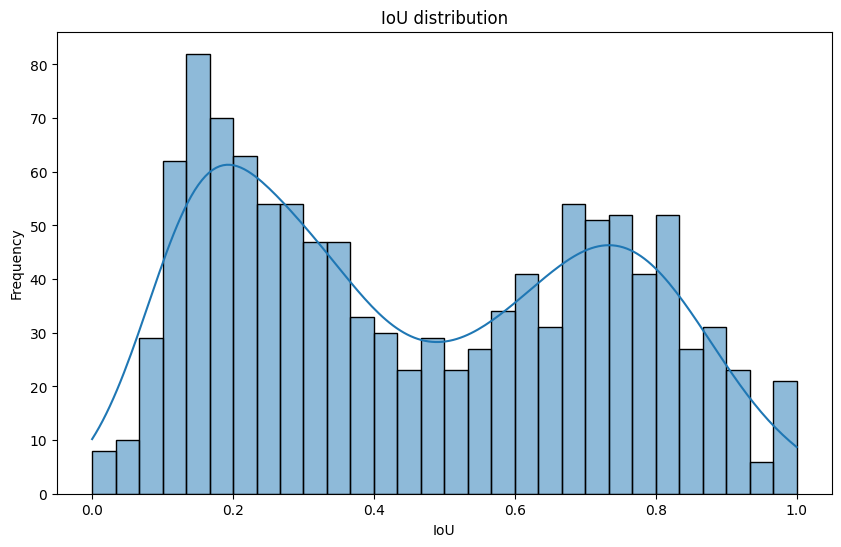

In [3]:
from src.visualizer import plot_iou_distribution

plot_iou_distribution(dataset_df=original_df)

As we can see, most of the bounding boxes are distributed in the ranges 0.1-0.4 and 0.6-0.9. We can see that the graph representing the IoU distribution is clearly bimodal, with two peaks around 0.2 and 0.8, indicating that the model is, generally speaking, either predicting a good bounding box that has a good overlap value, or either predicting a bad box with a low overlap value.

We will choose 0.5 as decision threshold since it is a generally good threshold over IoU for object detection tasks. Moreover, by looking at this graph, we can decide to use as threshold for the detection the value 0.5, which will give us a good threshold to correctly discriminate between good and bad predictions. Let's now add another field to the dataframe that contains the result of the classification depending on this IoU threshold.

In [4]:
from src.metrics import compute_detection_predictions

df_05 = compute_detection_predictions(dataset_df=original_df, detection_iou_threshold=0.5)

## Quantitative analysis
We will now perform a quantitative analysis of the model. By computing the detections using the previously defined threshold, we can now compute detection metrics.

We will use:
- **accuracy**: the number of correct predictions over the total number of predictions ($ accuracy = \frac{TP + TN}{TP + FP + TN + FN} $)
- **precision**: the number of correct positive predictions over the number of samples predicted as positives ($ precision = \frac{TP}{TP + FP} $)
- **recall**: the number of correct positive predictions over the number of samples that were originally supposed to be predicted as positives ($ recall = \frac{TP}{TP + FN} $)
- **f1 score**: a combination of precision and recall (the harmonic mean between the twos) ($ F1 = 2 * \frac{precision * recall}{precision + recall} $)
- number of TP, FP, TN and FN
- Mean Squared Error and Mean Absolute Error between the corners coordinates of predicted and ground truth bounding boxes for positively predicted samples

where TP are True Positives, FP are False Positives, TN are True Negatives and FN are False Negatives.

In our case, each row of the dataframe represents a sample of the positive class. This means that we don't have samples representing the negative class, which also means that:
- the number of True Negatives is going to be 0, since we won't have any sample of the negative class
- the number of False Positives is going to be 0 for the same reason

With this assumption, we can rewrite the previous metrics formulas as:
- $ accuracy = \frac{TP}{TP + FN} $
- $ precision = \frac{TP}{TP} $

meaning that:
- accuracy is going to be the same as recall
- precision is always going to be 1

Given these assumptions, we now compute all the previous metrics to perform the analysis.

Detection report for threshold 0.5:
Accuracy: 0.44
Precision: 1.00
Recall: 0.44
F1 Score: 0.61
Total samples: 1155
True Positives: 510
False Positives: 0
True Negatives: 0
False Negatives: 645
Mean Absolute Error (MAE) for x_start: 1.16
Mean Absolute Error (MAE) for x_end: 1.18
Mean Absolute Error (MAE) for y_start: 1.13
Mean Absolute Error (MAE) for y_end: 1.16
Mean Squared Error (MSE) for x_start: 2.91
Mean Squared Error (MSE) for x_end: 3.69
Mean Squared Error (MSE) for y_start: 3.21
Mean Squared Error (MSE) for y_end: 2.84


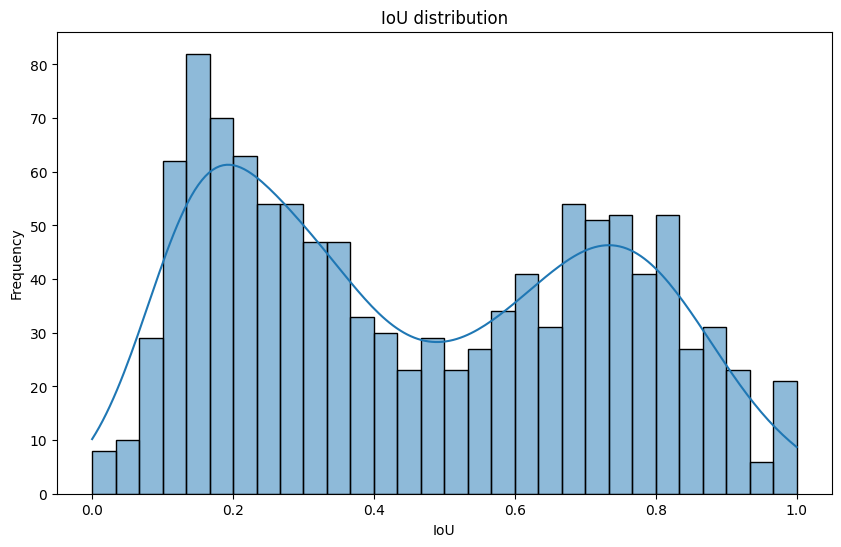

In [5]:
from src.visualizer import detection_report

print("Detection report for threshold 0.5:")
detection_report(dataset_df=df_05)

As we can see, with an accuracy/recall value of 0.44, the model doesn't perform. This is due to the fact that, as we can see from the IoU distribution, most samples are distributed in the IoU range 0.0-0.5. This range will then contain more samples than the range in which positive predictions lie (0.5-1.0). This behaviour can also be observed by also looking at the number of False Negatives, which is very high and in general much higher than the number of True Positives. 

The model does better in terms of F1 score but, as said before, this metric is not useful for this task because we don't have samples for the negative class and thus the precision is always 1.

We can try to lower the decision threshold a bit, but being 0.5 already quite low, lowering it more will increase the accuracy but also increase the errors of boxes corners, because we'll include more and more boxes that are less locally precise.

Let's try to set the decision threshold to 0.3.

Detection report for threshold 0.3:
Accuracy: 0.62
Precision: 1.00
Recall: 0.62
F1 Score: 0.77
Total samples: 1155
True Positives: 719
False Positives: 0
True Negatives: 0
False Negatives: 436
Mean Absolute Error (MAE) for x_start: 2.62
Mean Absolute Error (MAE) for x_end: 2.94
Mean Absolute Error (MAE) for y_start: 1.47
Mean Absolute Error (MAE) for y_end: 1.50
Mean Squared Error (MSE) for x_start: 22.99
Mean Squared Error (MSE) for x_end: 32.15
Mean Squared Error (MSE) for y_start: 4.46
Mean Squared Error (MSE) for y_end: 4.28


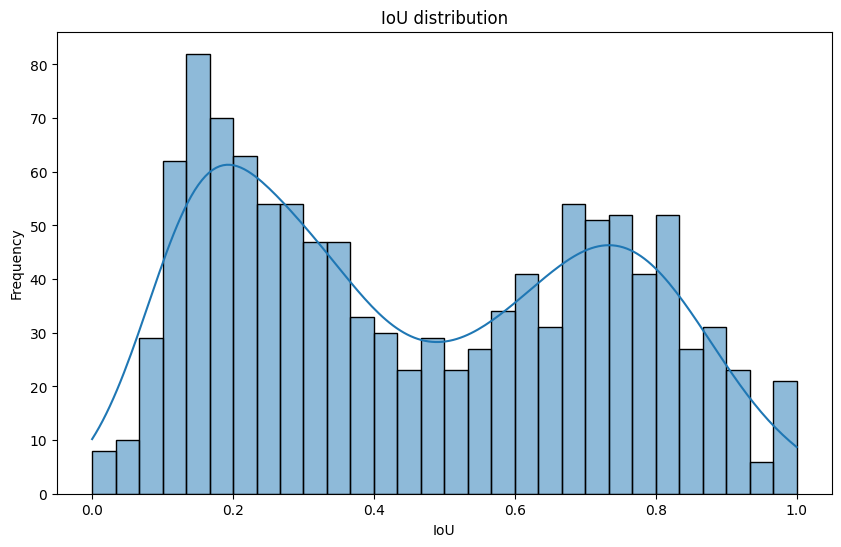

In [6]:
df_03 = compute_detection_predictions(dataset_df=original_df, detection_iou_threshold=0.3)
print("Detection report for threshold 0.3:")
detection_report(dataset_df=df_03)

As expected, we can see that the number of true positives increased and is now higher than the number of false negatives (the latter also decreased). This leads to accuracy increasing to 0.62, but at the same time the average error between the corners of the predicted boxex and the ground truth boxes increased too, indicating that this evaluation metric now considers also more boxes that are not locally precise, potentially leading to including boxes not fitting any nodule.

Let's now perform the same analysis for each nodule class to see how well the model behaves with respect to each class. We'll keep using the decision threshold 0.5.

Detection report for class solid with threshold 0.5
Accuracy: 0.20
Precision: 1.00
Recall: 0.20
F1 Score: 0.34
Total samples: 700
True Positives: 142
False Positives: 0
True Negatives: 0
False Negatives: 558
Mean Absolute Error (MAE) for x_start: 1.14
Mean Absolute Error (MAE) for x_end: 1.38
Mean Absolute Error (MAE) for y_start: 0.99
Mean Absolute Error (MAE) for y_end: 1.19
Mean Squared Error (MSE) for x_start: 2.92
Mean Squared Error (MSE) for x_end: 4.72
Mean Squared Error (MSE) for y_start: 1.42
Mean Squared Error (MSE) for y_end: 2.08


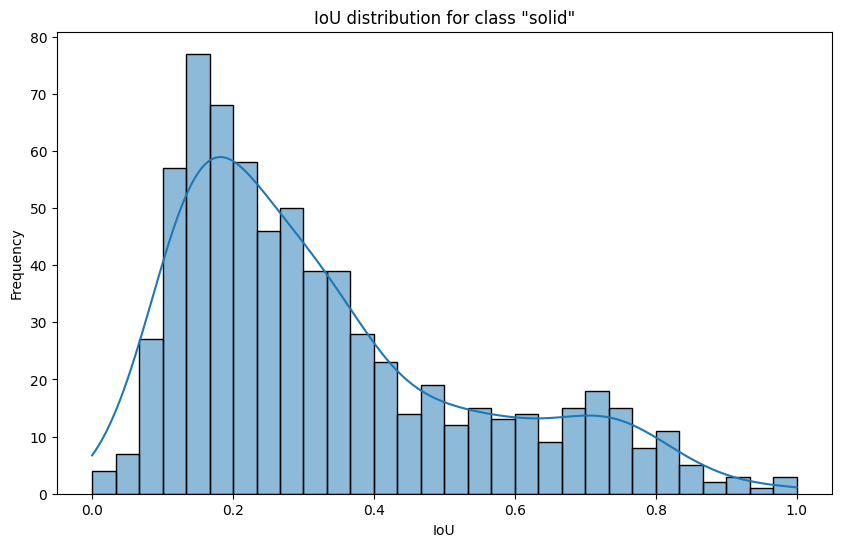

Detection report for class unknown with threshold 0.5
Accuracy: 0.95
Precision: 1.00
Recall: 0.95
F1 Score: 0.97
Total samples: 301
True Positives: 286
False Positives: 0
True Negatives: 0
False Negatives: 15
Mean Absolute Error (MAE) for x_start: 1.05
Mean Absolute Error (MAE) for x_end: 0.95
Mean Absolute Error (MAE) for y_start: 1.07
Mean Absolute Error (MAE) for y_end: 1.02
Mean Squared Error (MSE) for x_start: 2.35
Mean Squared Error (MSE) for x_end: 2.83
Mean Squared Error (MSE) for y_start: 3.31
Mean Squared Error (MSE) for y_end: 2.74


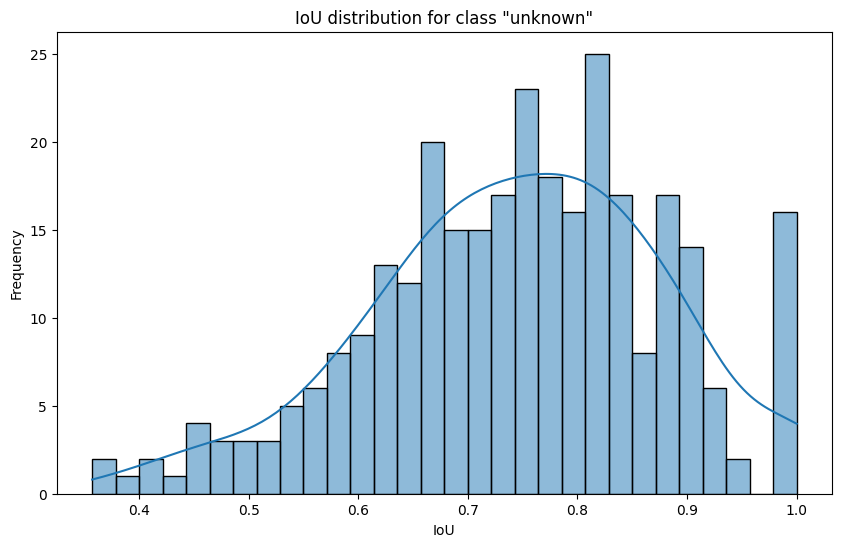

Detection report for class non-solid with threshold 0.5
Accuracy: 0.43
Precision: 1.00
Recall: 0.43
F1 Score: 0.60
Total samples: 122
True Positives: 52
False Positives: 0
True Negatives: 0
False Negatives: 70
Mean Absolute Error (MAE) for x_start: 1.73
Mean Absolute Error (MAE) for x_end: 1.60
Mean Absolute Error (MAE) for y_start: 1.52
Mean Absolute Error (MAE) for y_end: 1.73
Mean Squared Error (MSE) for x_start: 4.69
Mean Squared Error (MSE) for x_end: 4.02
Mean Squared Error (MSE) for y_start: 4.21
Mean Squared Error (MSE) for y_end: 5.00


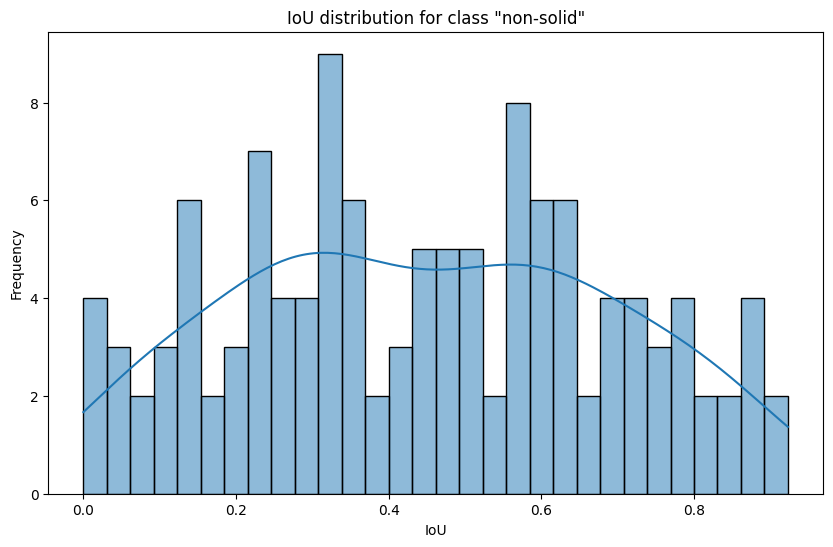

Detection report for class part-solid with threshold 0.5
Accuracy: 0.94
Precision: 1.00
Recall: 0.94
F1 Score: 0.97
Total samples: 32
True Positives: 30
False Positives: 0
True Negatives: 0
False Negatives: 2
Mean Absolute Error (MAE) for x_start: 1.37
Mean Absolute Error (MAE) for x_end: 1.77
Mean Absolute Error (MAE) for y_start: 1.70
Mean Absolute Error (MAE) for y_end: 1.27
Mean Squared Error (MSE) for x_start: 5.10
Mean Squared Error (MSE) for x_end: 6.43
Mean Squared Error (MSE) for y_start: 8.90
Mean Squared Error (MSE) for y_end: 3.67


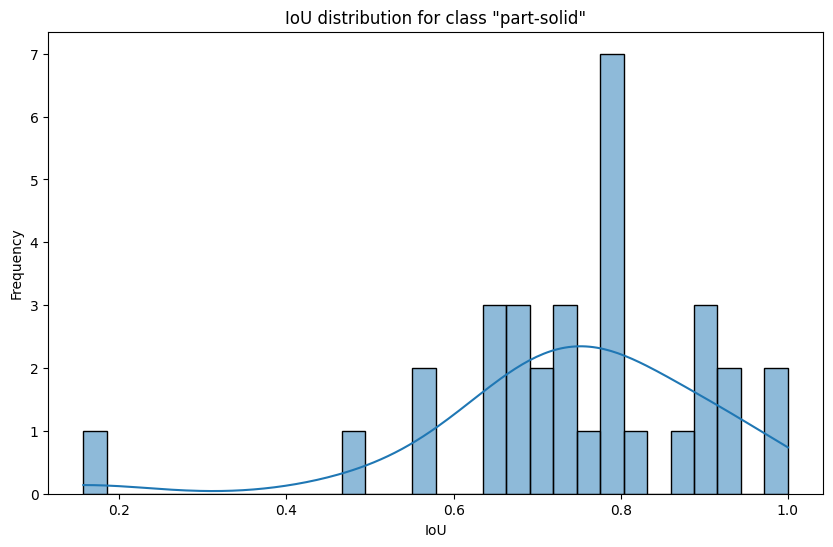

In [7]:
for cls in df_05['gt-composition'].unique():
    filtered_data = df_05[df_05['gt-composition'] == cls]

    print(f"Detection report for class {cls} with threshold 0.5")
    detection_report(dataset_df=filtered_data, class_type=cls)


For the class `solid`, we can see that the model doesn't perform very well, hitting an accuracy/recall of 0.20. We can also see a higher number of false negatives w.r.t. true positives and a high value of false negatives due to the fact that the IoU distribution looks unimodal, with a peak around 0.2 and most of the samples in the range 0.0-0.5. This is also the most represented class, giving a high contribution to the performances of the whole model.

For the class `unknown`, we can see that the model performs very well, hitting an accuracy/recall of 0.95. We can also see a higher number of true positives w.r.t. false negatives and a high value of true positives. The IoU distribution is unimodal, with a peak around 0.3 and most of the samples in the positive range 0.5-1.0, explaining why the model performs good on this class.

For the class `non-solid`, the model performances are aligned with the general performances, with an accuracy/recall of 0.43. We can see that there are more false negatives than true positives, although the difference is not so notable. The IoU distribution is bimodal, with two peaks around 0.3 and 0.8.

For the class `part-solid`, the model performs very well, with an accuracy/recall of 0.94. There's a high number of true positives, which is also higher than the number of false negatives, and this is explained by the IoU distribution graph that is clearly unimodal, with a peak around 0.8 and most samples in the range 0.5-1.0.

As we can see from the number of samples for each class, the class that contributes the most to the whole performances of the model is `solid`, immediately followed by `unknown`, `non-solid` and `part-solid`, with the model performance performing very bad on `solid` and very good on `unknown` and `part-solid`, this explains why the model performs on average very bad.

## Conclusion on quantitative analysis
We can see that the model performs not so well. The distribution of IoU clearly shows that the model fits bounding boxes with on average a lower IoU with ground truth boxes. We also can see how lowering the decision threshold doesn't contribute to improving the performances of the model because it simply alters the scores by adding more bounding boxes to the positives, but these newly added boxes are not so locally precise and can lead to wrongly classify samples that don't fit nodules precisely. We can also see how the model performs good on some classes and bad on other classes and we can see that there's a class which is most represented in the dataset on which the model performs very bad, leading to a bad general performance. This also shows that the model does not perform uniformly across different composition types.

## Qualitative analysis
Let's now look at few samples and qualitatively see how the model performs. Let's first see few examples of a good prediction, by looking at samples with an IoU with the ground truth box greater than 0.7.

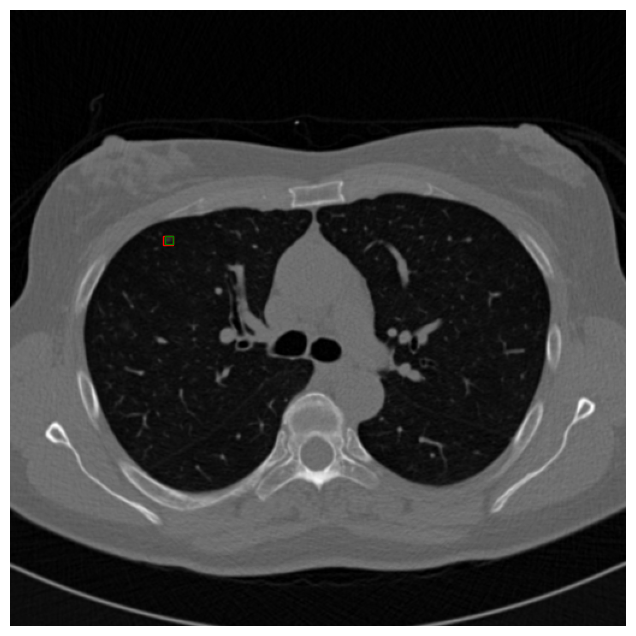

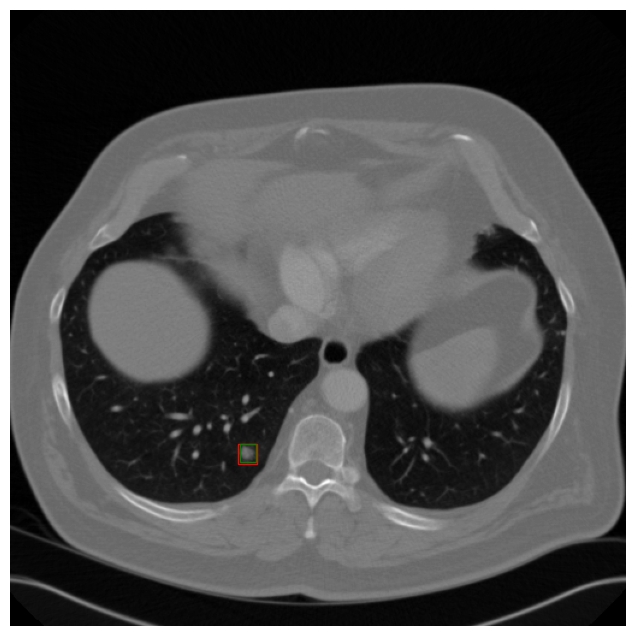

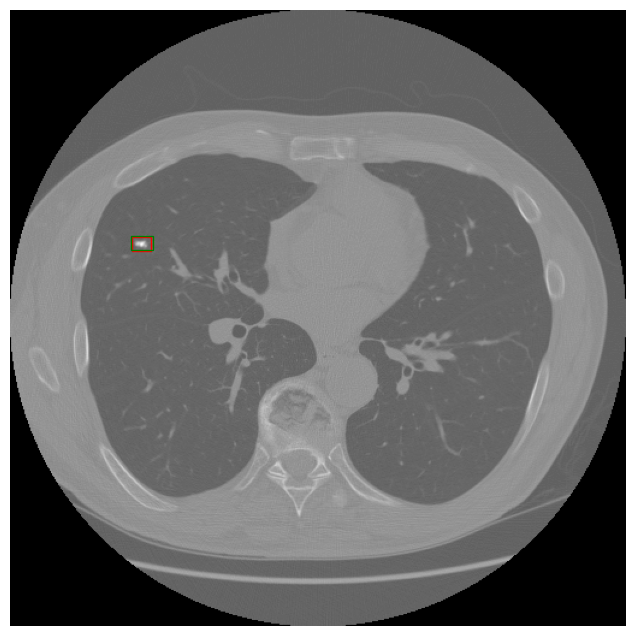

In [8]:
from src.visualizer import visualize_few_samples

good_samples = original_df[original_df['iou'] > 0.7]
visualize_few_samples(good_samples, n_samples=3, random_state=42)

We can see how in case of good predictions, the predicted bounding box (colored in green) is mostly centered with the ground truth bounding box (colored in red). Moreover, the predicted box is also close in size with respect to the ground truth box.

Let's now look at some bad predictions.

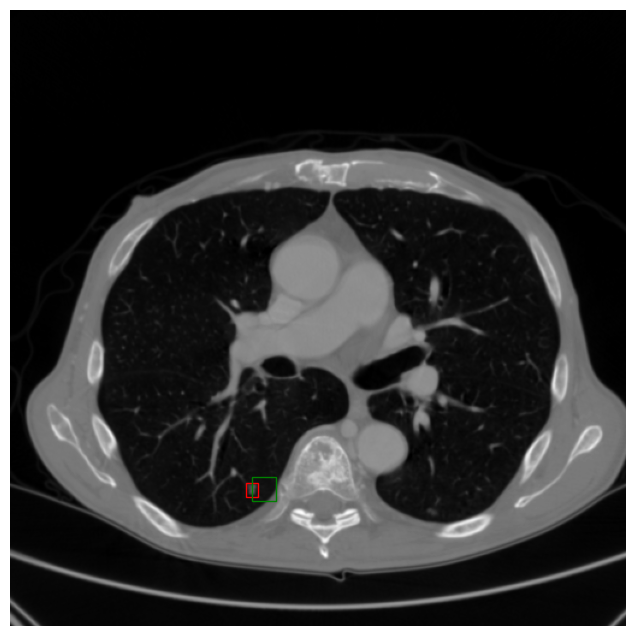

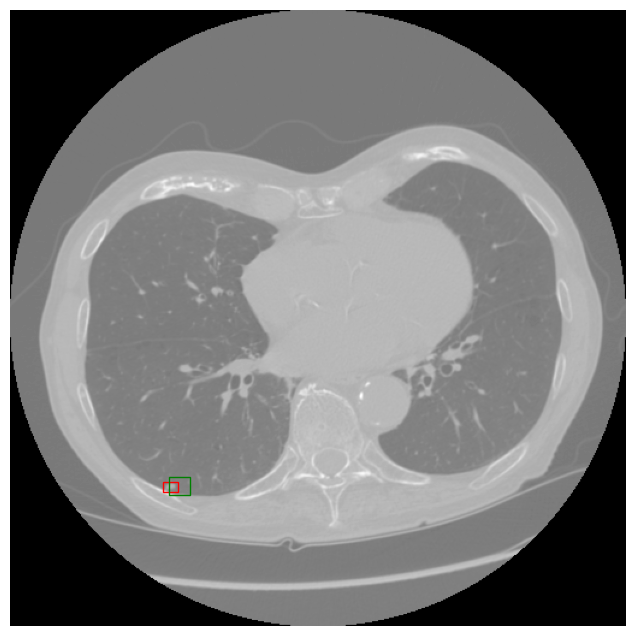

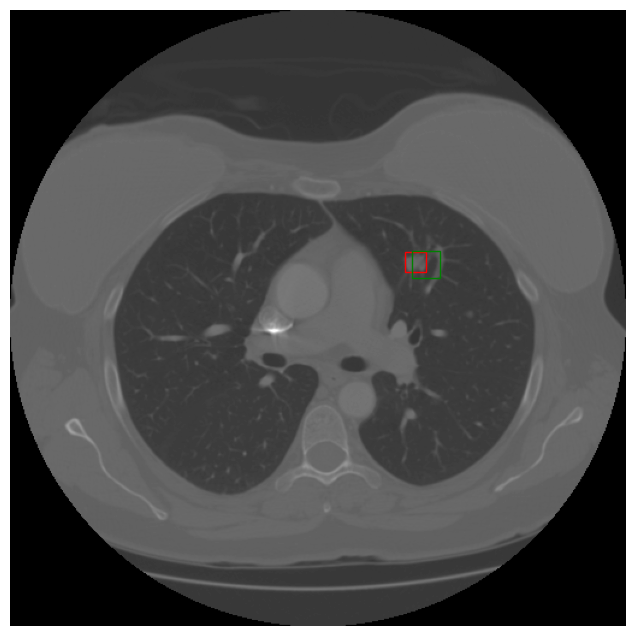

In [9]:
samples = original_df[original_df['iou'] < 0.3]
visualize_few_samples(samples, n_samples=3, random_state=42)

We can see how, in case of bad predictions, the predicted bounding box (colored in green) is very different and has a very low area of overlap with respect to the ground truth bounding box (colored in red). It is also possible to see how, in case of bad predictions, the center of the predicted box is off with respect to the center of the ground truth box. Moreover, the predicted box is usually bigger and more to the right w.r.t. the ground truth box.

## Conclusion on qualitative analysis
We can se how in case of good predictions, the predicted bounding box is closer to the ground truth, both in size and position, explaining why the IoU between the two boxes is high. On the other hand, in case of bad predictions, the predicted bounding box is usually bigger and more to the right with respect to the ground truth box, explaining why the IoU between the two boxes is low. Moreover, this shows that the principal failure mode of the model is a systematic oversizing and a systematic positioning to the right of the predicted bounding box.